## Step 0: Import Libraries

In [28]:
import gaston_dynamics as gd
import scanpy as sc
import numpy as np 
import pandas as pd

In [2]:
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch
import seaborn as sns
import math

### Import GASTON

In [3]:
import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

### Format Data for Ligand Receptor Analysis

Here we convert our csv of known ligand receptor pairs and filter to only include those for Mouse.

In [4]:
df = pd.read_csv('lrpairs.csv') #for ligand receptor analysis

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


# Filtering the DataFrame
mouse_df = df[df['species'] == 'Mouse']

# Display the filtered data
print(mouse_df)

       ligand receptor species
3398     Wnt3     Fzd6   Mouse
3399     Wnt3     Egfr   Mouse
3400     Wnt3     Fzd2   Mouse
3401     Wnt3     Lrp5   Mouse
3402     Wnt3     Fzd1   Mouse
...       ...      ...     ...
5422     Nrg4    Erbb4   Mouse
5423  Adamts3    Ccbe1   Mouse
5424     Bmp6   Acvr2b   Mouse
5425    Pdgfd   Pdgfra   Mouse
5426     Apoe    Vldlr   Mouse

[2029 rows x 3 columns]


## Step 1: Pre Processing

GASTON requires:

- N x G counts matrix

- N x 2 spatial coordinate matrix,

- list of names for each gene

where N=number of spatial locations and G=number of genes.

We will be pre-processing using GLM-PCA, though there are other options listed in the GASTON tutorial.

### GLMPCA

In [5]:
!mkdir -p tutorial_outputs

In [6]:
counts_mat=np.load('cerebellum_data/cerebellum_counts_mat.npy') # N x G UMI count array
coords_mat=np.load('cerebellum_data/cerebellum_coords_mat.npy') # N x 2 spatial coordinate matrix
gene_labels=np.load('cerebellum_data/cerebellum_gene_labels.npy', allow_pickle=True) # list of names for G genes

In [7]:
# OPTIONAL: filter out cells with UMI below spot_umi_threshold
spot_umi_threshold=0

spots_to_keep=np.sum(counts_mat, axis=1)>=spot_umi_threshold
print(f'number of removed spots: {counts_mat.shape[0]-spots_to_keep.sum()}')
counts_mat=counts_mat[spots_to_keep,:]
coords_mat=coords_mat[spots_to_keep,:]

number of removed spots: 0


GLM-PCA typically takes 10-30 minutes to run. To improve the run-time of GLM-PCA, there are three parameters that can be adjusted.

1. Number of iterations `num_iters` - smaller value reduces runtime

2. Convergence threshold `eps` - larger value reduces runtime

3. Number of genes `num_genes` - smaller value reduces runtime

In [8]:
# GLM-PCA parameters
num_dims=8 # 2 * number of clusters
penalty=10 # may need to increase if this is too small

# CHANGE THESE PARAMETERS TO REDUCE RUNTIME
num_iters=30
eps=1e-4
num_genes=30000

counts_mat_glmpca=counts_mat[:,np.argsort(np.sum(counts_mat, axis=0))[-num_genes:]]
glmpca_res=glmpca.glmpca(counts_mat_glmpca.T, num_dims, fam="poi", penalty=penalty, verbose=True,
                        ctl = {"maxIter":num_iters, "eps":eps, "optimizeTheta":True})
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

np.save('tutorial_outputs/glmpca.npy', A)

Iteration: 0 | deviance=2.4128E+7
Iteration: 1 | deviance=2.4128E+7
Iteration: 2 | deviance=2.3962E+7
Iteration: 3 | deviance=2.2857E+7
Iteration: 4 | deviance=2.2499E+7
Iteration: 5 | deviance=2.2405E+7
Iteration: 6 | deviance=2.2350E+7
Iteration: 7 | deviance=2.2311E+7
Iteration: 8 | deviance=2.2282E+7
Iteration: 9 | deviance=2.2261E+7
Iteration: 10 | deviance=2.2245E+7
Iteration: 11 | deviance=2.2234E+7
Iteration: 12 | deviance=2.2225E+7
Iteration: 13 | deviance=2.2218E+7
Iteration: 14 | deviance=2.2212E+7
Iteration: 15 | deviance=2.2207E+7
Iteration: 16 | deviance=2.2204E+7
Iteration: 17 | deviance=2.2200E+7
Iteration: 18 | deviance=2.2198E+7
Iteration: 19 | deviance=2.2195E+7


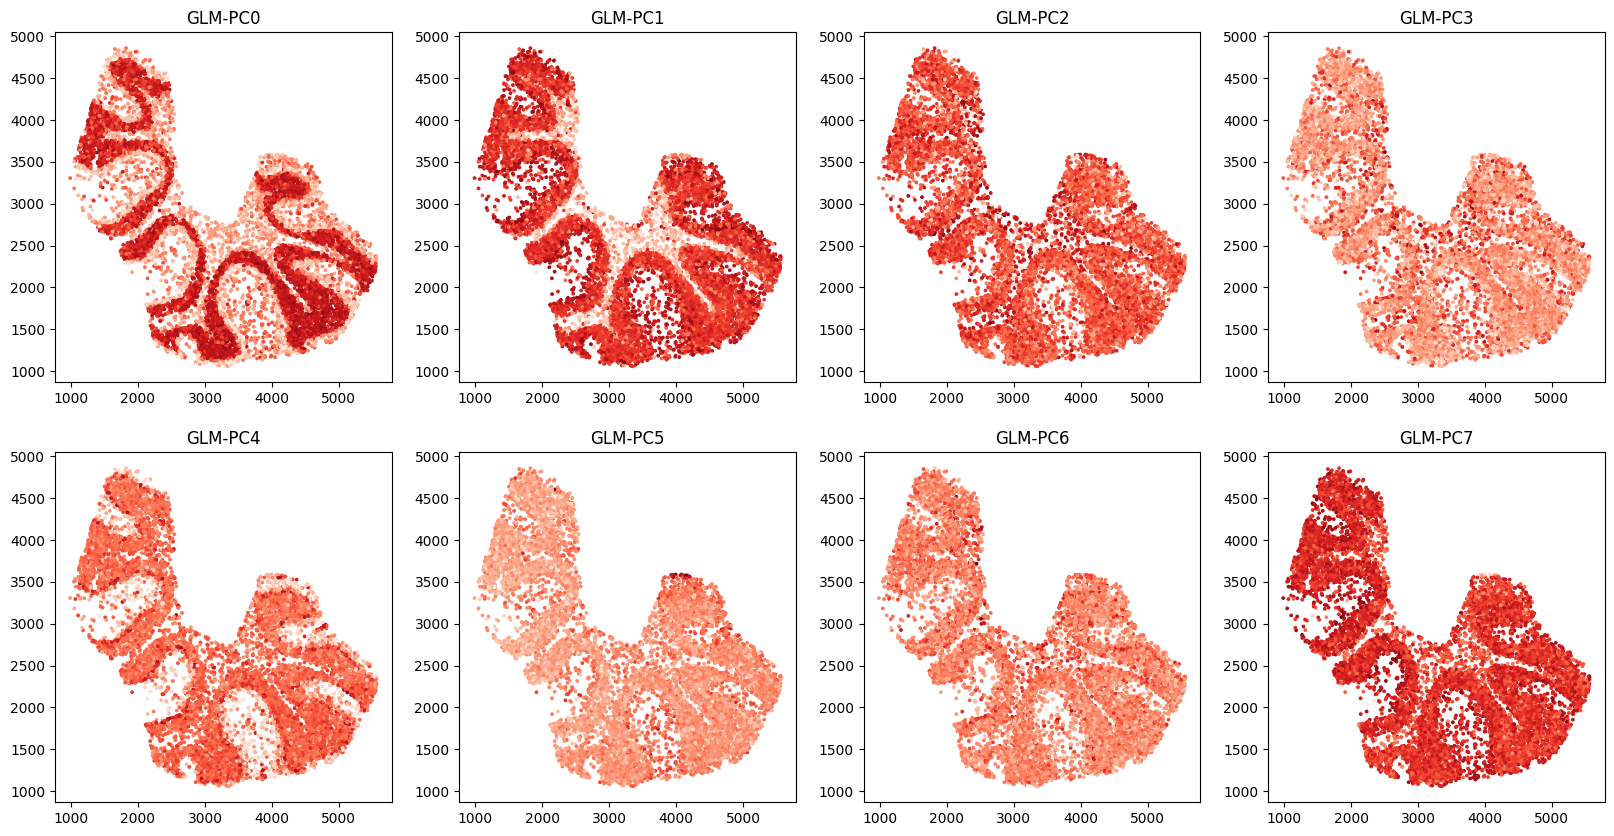

In [9]:
# visualize top GLM-PCs
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(coords_mat[:,0], coords_mat[:,1], c=A[:,i],cmap='Reds',s=3)
        axs[r,c].set_title(f'GLM-PC{i}')

## Step 2: Train GASTON neural network

We typically train the neural network 30 different times, each with a different seed, and we use the NN with lowest loss. We will be training in notebook, view the GASTON tutorial for an Slurm option.

We first load GLM-PCs and coordinates and z-score normalize.

In [10]:
# Load N x G matrix A of GLM-PCs, and N x 2 matrix S
# A=np.load('tutorial_outputs/glmpca.npy') # GLM-PCA results from above
A=np.load('cerebellum_data/F_glmpca_penalty_10_rep1.npy') # GLM-PCA results used in manuscript
S=coords_mat

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

Next we train the neural network, once for each random initialization.

In [11]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='tutorial_outputs' # folder to save model runs
optimizer = "adam"
num_restarts=30

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

training neural network for seed 0
training neural network for seed 1
training neural network for seed 2
training neural network for seed 3
training neural network for seed 4
training neural network for seed 5
training neural network for seed 6
training neural network for seed 7
training neural network for seed 8
training neural network for seed 9
training neural network for seed 10
training neural network for seed 11
training neural network for seed 12
training neural network for seed 13
training neural network for seed 14
training neural network for seed 15
training neural network for seed 16
training neural network for seed 17
training neural network for seed 18
training neural network for seed 19
training neural network for seed 20
training neural network for seed 21
training neural network for seed 22
training neural network for seed 23
training neural network for seed 24
training neural network for seed 25
training neural network for seed 26
training neural network for seed 27
tr

## Step 3: Process neural network output

If you use the model trained above, then figures will closely match the GASTON manuscript — but not exactly match — due to PyTorch non-determinism in seeding (see https://github.com/pytorch/pytorch/issues/7068 ).

Load best model

In [12]:
# MODEL TRAINED ABOVE
# gaston_model, A, S= process_NN_output.process_files('tutorial_outputs')

# TO MATCH PAPER FIGURES
gaston_model, A, S= process_NN_output.process_files('cerebellum_data/reproduce_cerebellum') 


best model: cerebellum_data/reproduce_cerebellum/seed19


## Step 4: GLACIER Pre-Processing

Now that we have a suitable GASTON model for isodepth computation, we can begin preparing the DAG for Velorama

First we must reformat some of the GASTON data for GLACIER DAG creation

In [13]:
#Reformats cell_type_df for kNN creation metrics
cell_type_mod_df = gd.create_cell_type_df('cerebellum_data/cell_type_df.csv')

Compute isodepth and gaston labels from model

In [14]:
flip = False #True for inverted isodepth

# CHANGE FOR YOUR APPLICATION: use number of domains from above!
num_layers=4 

scale_factor=64/100 # since 64 pixels = 100 microns in slide-seq image

gaston_isodepth, gaston_labels = gd.calculate_isodepth(gaston_model, A, S, coords_mat, num_layers=num_layers,
    scale_factor=scale_factor, flip=flip, adjust = True)

### Spatially varying gene analysis

Compute piecewise linear fit for every gene

In [15]:
# if you want to get rid of warnings

import warnings
warnings.filterwarnings("ignore")
ct_list= [] #cell type information is not needed for GLACIER
cell_type_df=pd.read_csv('cerebellum_data/cell_type_df.csv', index_col=0)
pw_fit_dict, binning_output = gd.binning_output(counts_mat, gene_labels, gaston_labels, gaston_isodepth, cell_type_df, ct_list, num_bins_per_domain=[20,40,20,20])

Poisson regression for ALL cell types


100%|██████████| 2193/2193 [00:31<00:00, 70.26it/s]


## Step 5: Create AnnData objects for Velorama

### Layer-wise AnnData

Graph construction completed in 0.0029 seconds


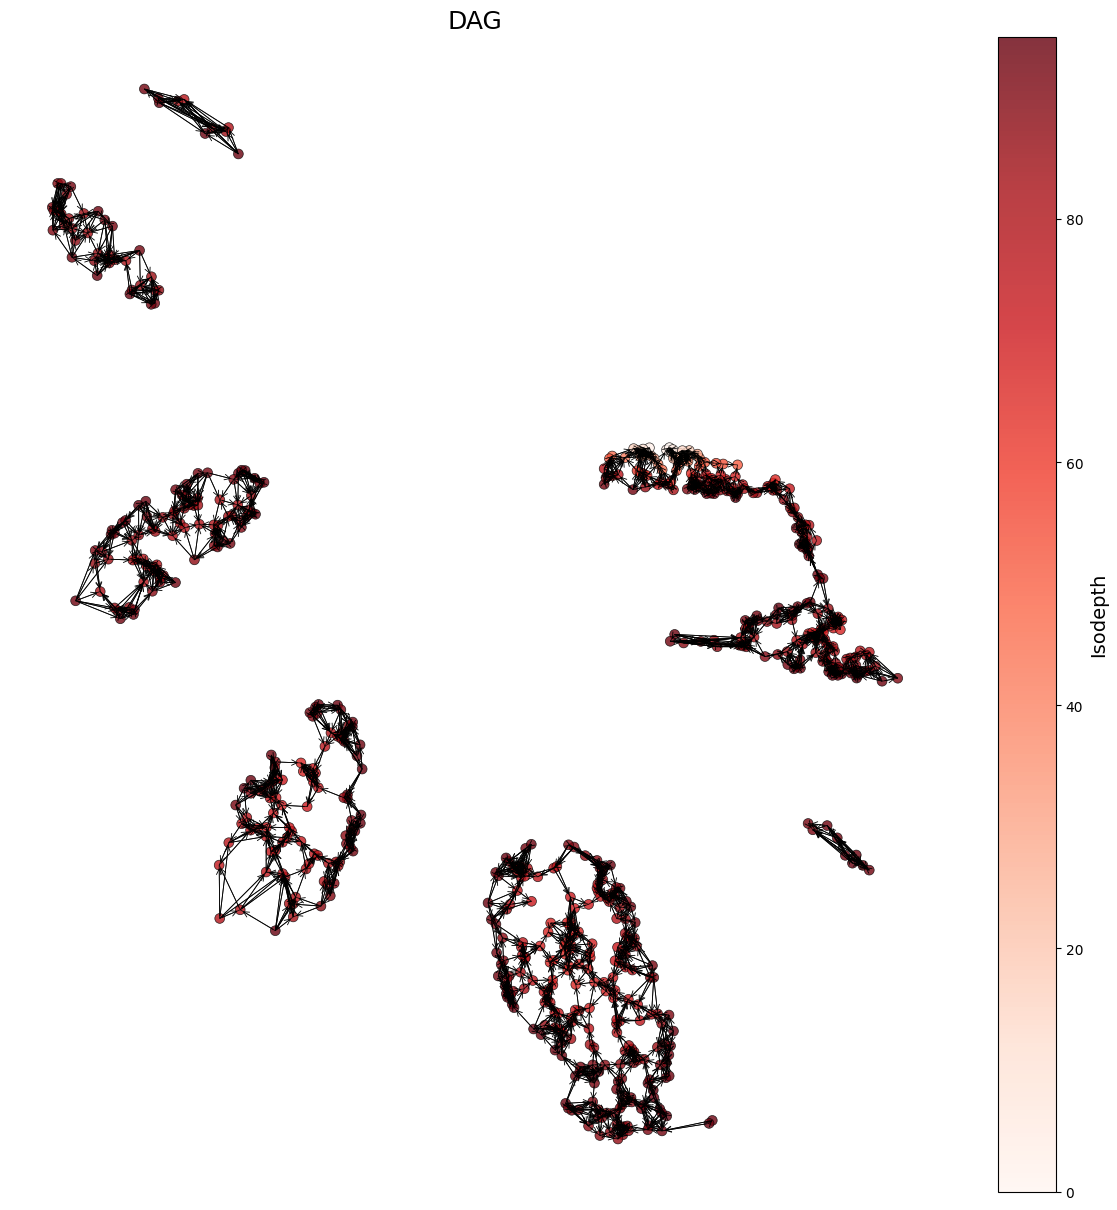

Graph construction completed in 0.0070 seconds


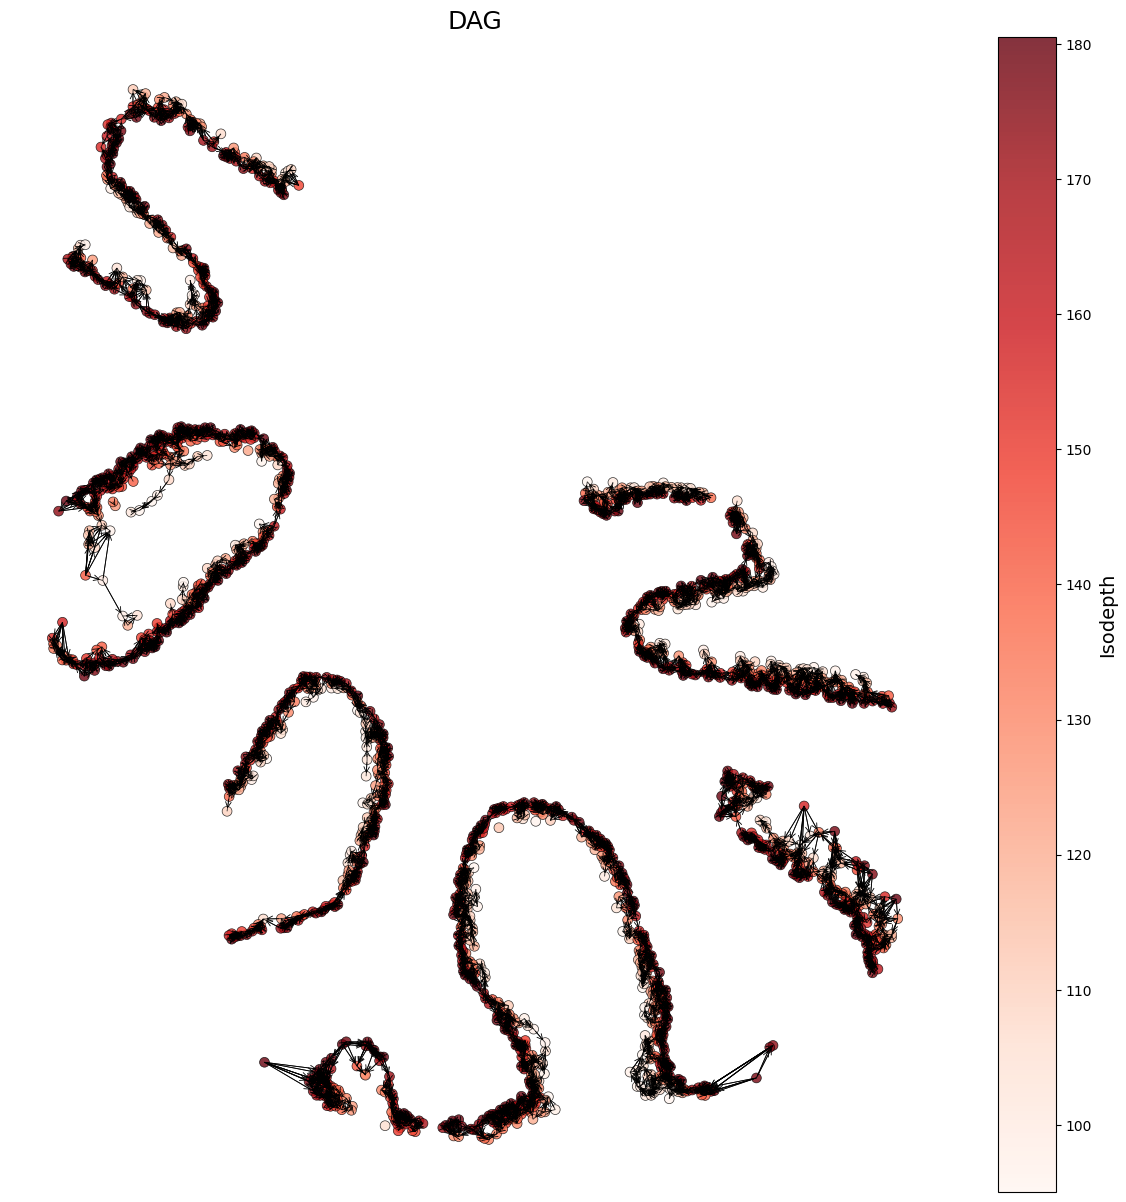

Graph construction completed in 0.0328 seconds


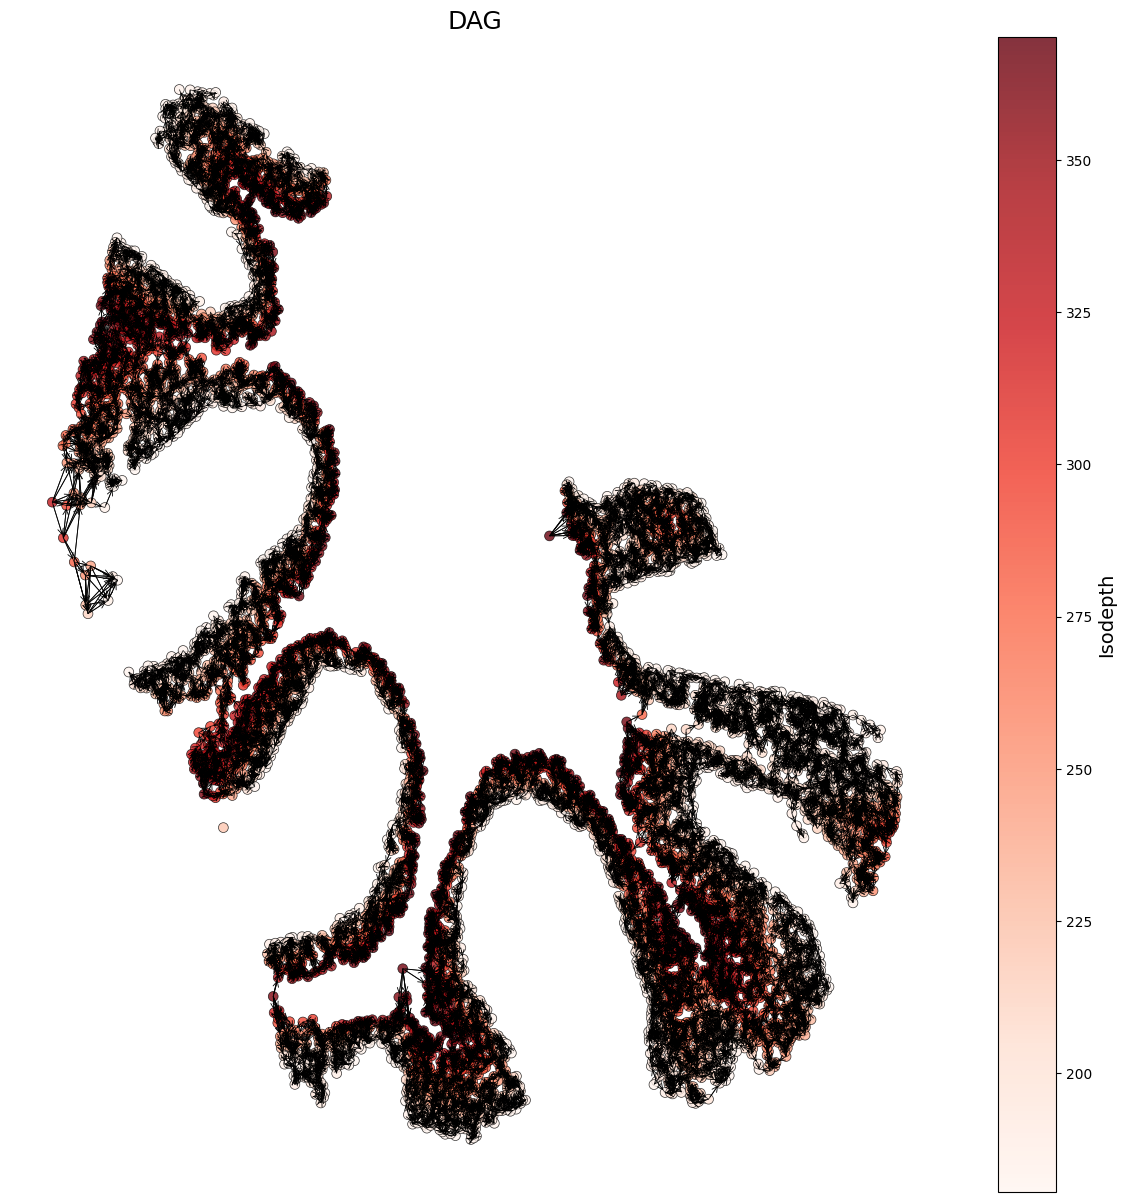

Graph construction completed in 0.0039 seconds


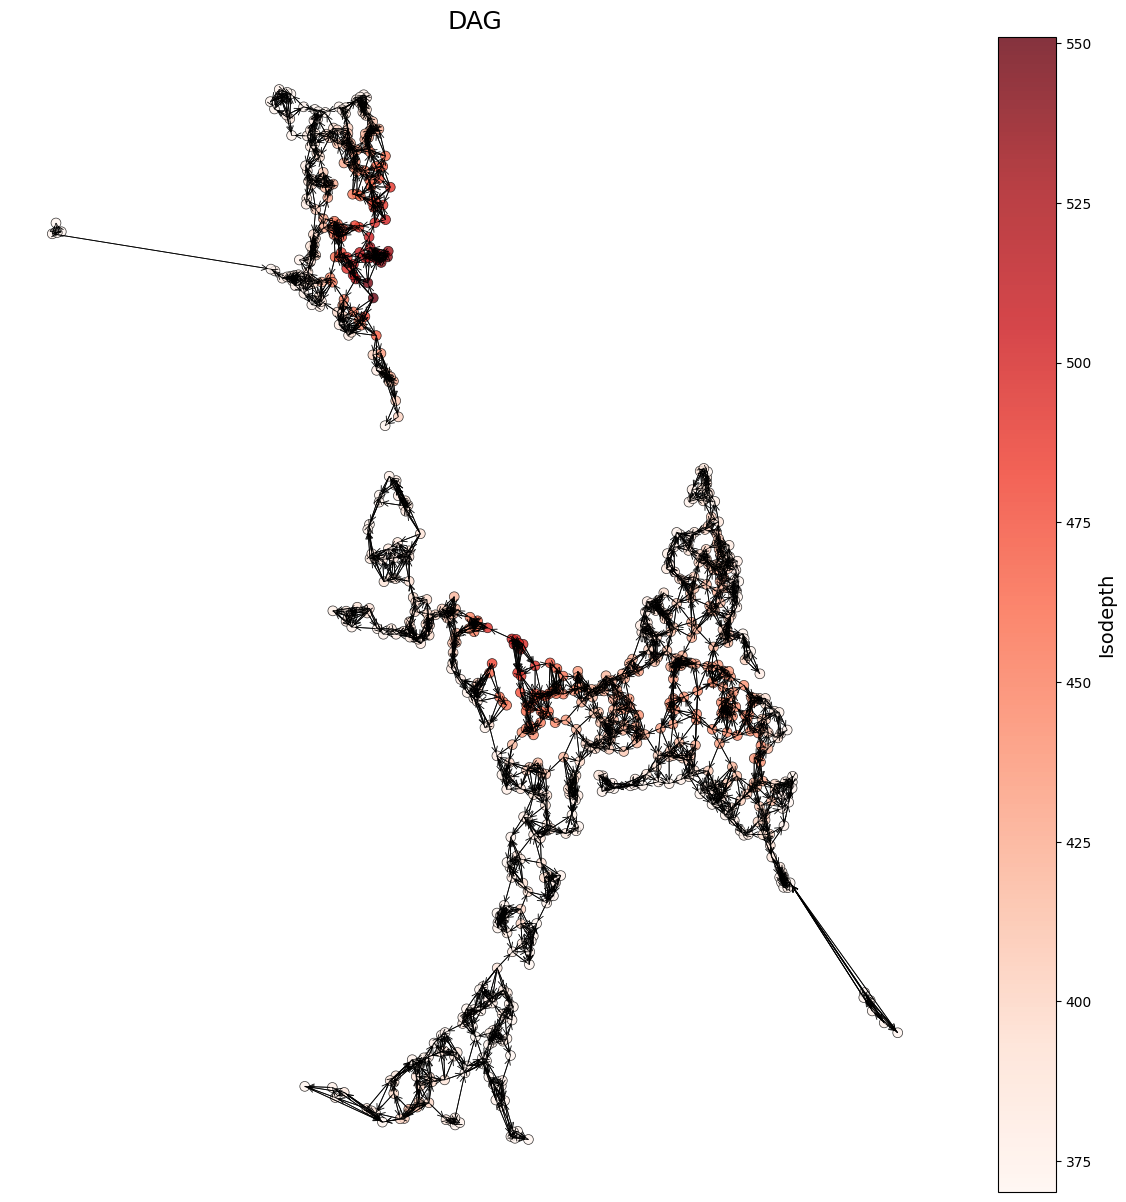

In [39]:
#Iterate over all layers
from importlib import reload
reload(gd)
boundaries = []
for l in range(num_layers):
    gaston_isodepth_l=gaston_isodepth[(gaston_labels == l)] #filter to current cell layer
    
    boundaries.append(max(gaston_isodepth_l)) #store isodepth boundary location for boundary analysis
    
    coords_mat_l = coords_mat[(gaston_labels == l), :]
    counts_mat_l=counts_mat[(gaston_labels == l), :]
    
    #Create AnnData from ST data
    df = pd.DataFrame(counts_mat_l, columns=gene_labels)
    adata=sc.AnnData(df)
    adata.obsm["coords"] = coords_mat_l
    
    #Construct DAG and add to AnnData
    dag_adjacency_matrix = gd.construct_dag(adata, gaston_isodepth_l, coords_mat_l, n_neighbors=7, plot=False)
    gd.plot_spatial_dag(dag_adjacency_matrix, coords_mat_l, gaston_isodepth_l, size = 50, arrow_size = 0.5, legend = True)
    
    #Split AnnData for either TF/Gene or L/R analysis
    adata_tf = adata.copy()
    adata_lr = adata.copy()
    
    #Create targets for each
    gd.create_tf_targets(adata_tf, pw_fit_dict, binning_output, q=0.9, file = 'transcription_factors.txt')
    gd.create_lr_targets(adata_lr, pw_fit_dict, binning_output, q=0.9)


### Boundary-wise AnnData

Graph construction completed in 0.0061 seconds


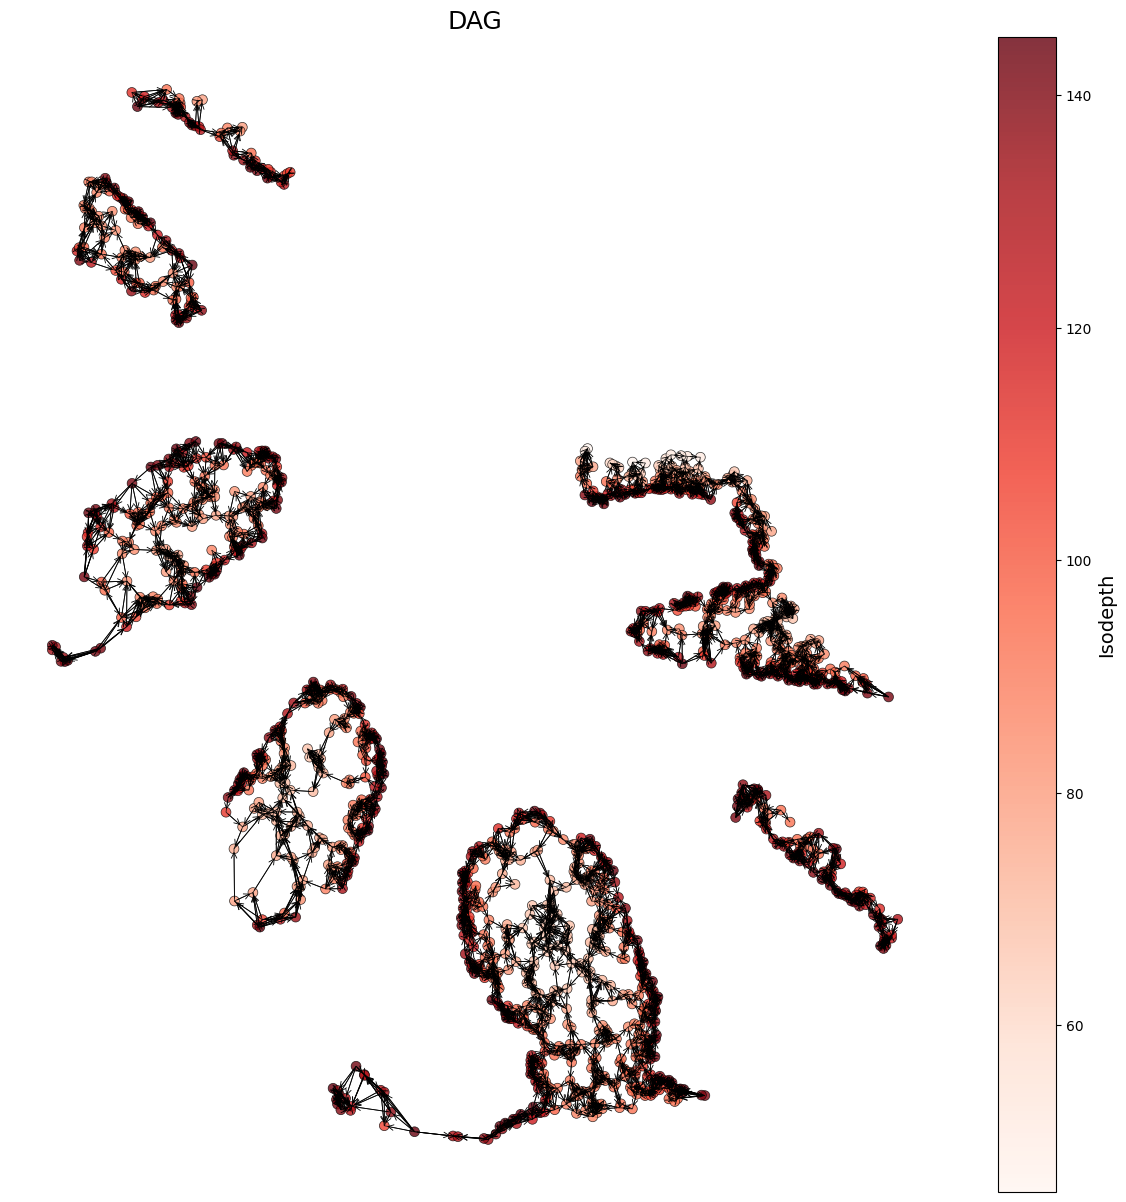

Graph construction completed in 0.0156 seconds


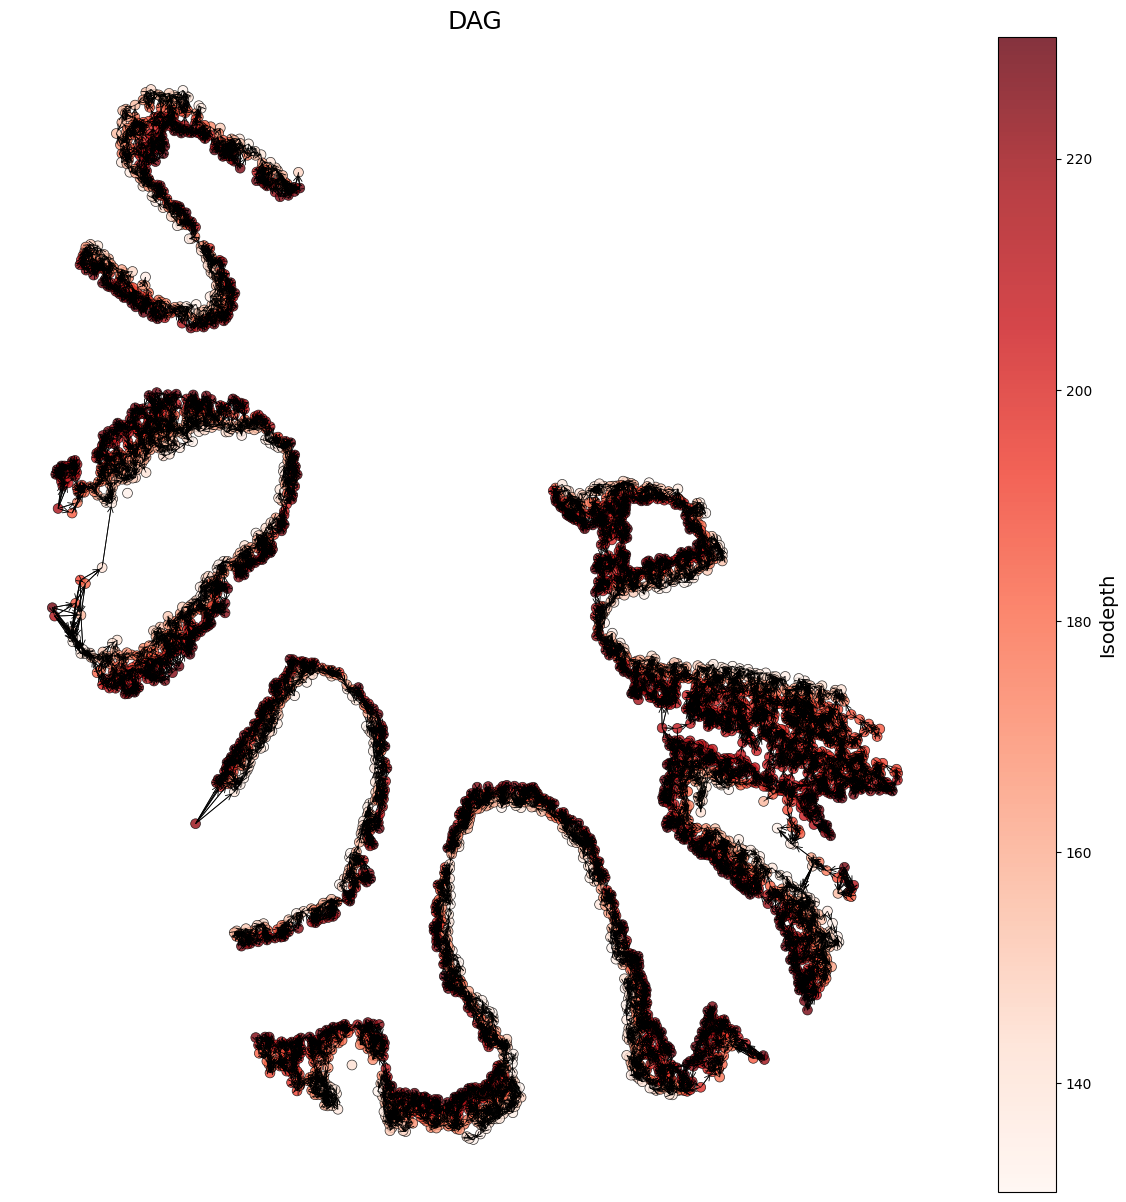

Graph construction completed in 0.0068 seconds


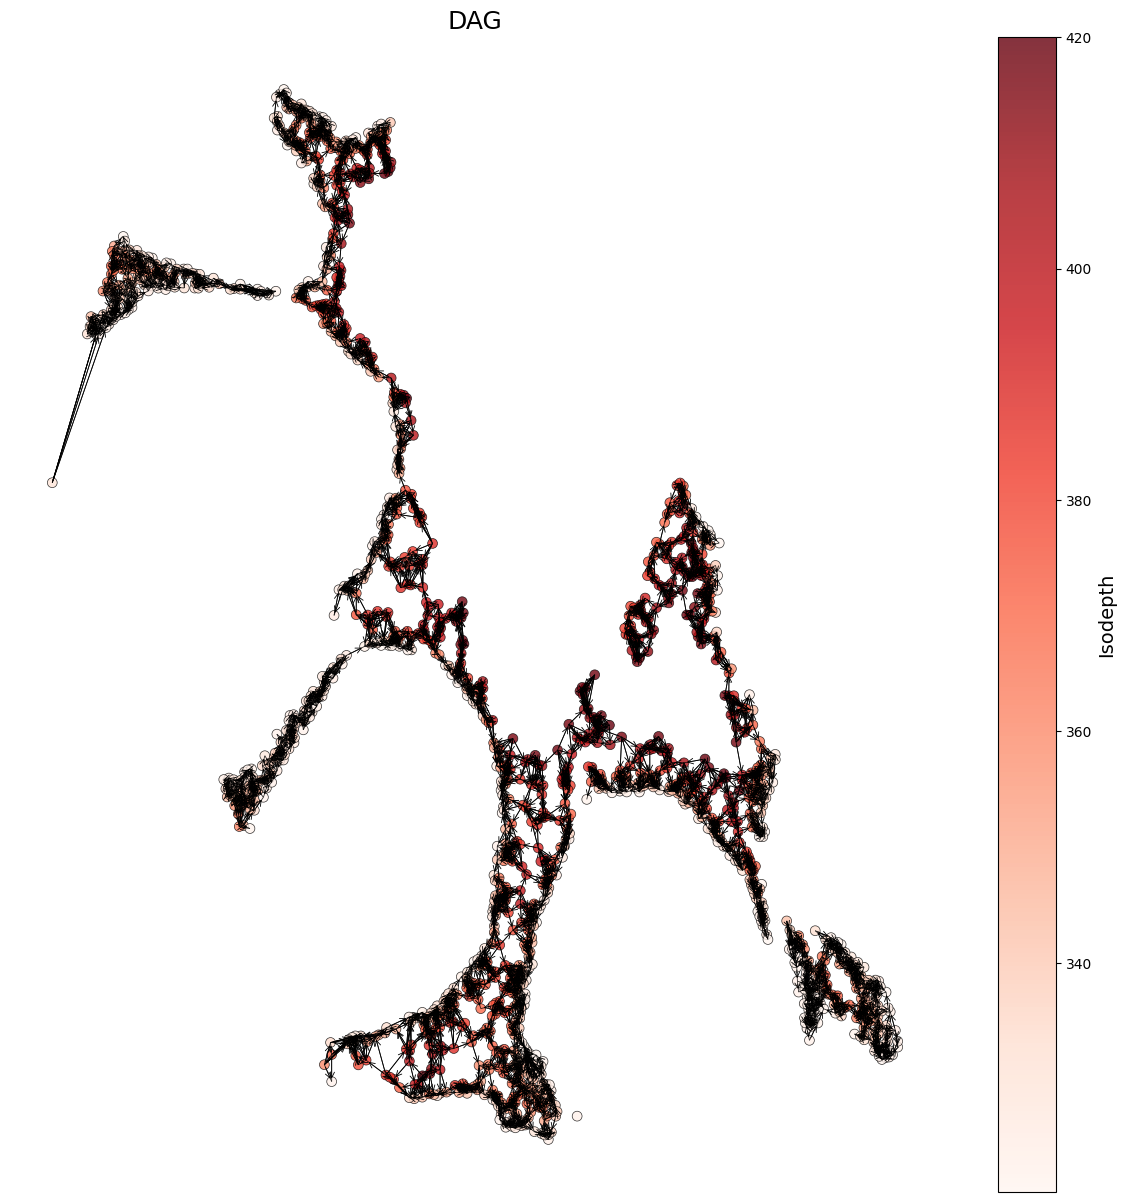

In [46]:
#Iterate over boundaries
boundary_size = 100 #adjust based on your needs
for l in range(len(boundaries) - 1):
    bound = boundaries[l]
    lower = bound - boundary_size//2
    upper = bound + boundary_size//2    
    
    gaston_isodepth_l = gaston_isodepth[(gaston_isodepth >= lower) & (gaston_isodepth <=  upper)] #filter to current isodepth range
    coords_mat_l = coords_mat[(gaston_isodepth >= lower) & (gaston_isodepth <= upper), :]
    counts_mat_l = counts_mat[(gaston_isodepth >= lower) & (gaston_isodepth <= upper), :]

    #Create AnnData from ST data
    df = pd.DataFrame(counts_mat_l, columns=gene_labels)
    adata=sc.AnnData(df)
    adata.obsm["coords"] = coords_mat_l
    
    #Construct DAG and add to AnnData
    dag_adjacency_matrix = gd.construct_dag(adata, gaston_isodepth_l, coords_mat_l, n_neighbors=7, plot=False)
    gd.plot_spatial_dag(dag_adjacency_matrix, coords_mat_l, gaston_isodepth_l, size = 50, arrow_size = 0.5, legend = True)
    
    #Split AnnData for either TF/Gene or L/R analysis
    adata_tf = adata.copy()
    adata_lr = adata.copy()
    
    #Create targets for each
    gd.create_tf_targets(adata_tf, pw_fit_dict, binning_output, q=0.9, file = 'transcription_factors.txt')
    gd.create_lr_targets(adata_lr, pw_fit_dict, binning_output, q=0.9)
